In [1]:
from direct_effect_analysis import DirectEffectAnalysis, MANCOVA
from utils import *
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import pearsonr
from pywhy_stats import independence_test, fisherz
import pywhy_stats as ps
from generalised_covariance_measure import GCM_translation
from collections import defaultdict
import seaborn as sns
from pywhy_stats.independence import kci, fisherz
from pgmpy.estimators import PC
import scipy
from plotnine import ggplot, aes, geom_tile, geom_text, scale_fill_gradient, labs, facet_wrap, theme, element_text, ggsave, scale_fill_cmap
from scipy.stats import norm


In [2]:
def parameters(r, p, q, d, H_0=True):
    beta = np.random.uniform(-1, 1, (r, p))
    beta = beta/np.linalg.norm(beta)
    gamma = np.random.uniform(-1, 1, (p, q))
    gamma = gamma/np.linalg.norm(gamma)
    A_x, A_z = np.random.uniform(-1, 1, (q, d)), np.random.uniform(-1, 1, (r, d))
    A_x, A_z = A_x/np.linalg.norm(A_x), A_z/np.linalg.norm(A_z)
    if H_0 :
        A_x = np.random.uniform(0, 0, (q, d))
    return A_x, A_z, beta, gamma

In [3]:
rk, r, p, q = 10, 1, 1, 1
samples = [50, 100, 200, 500, 1000]
dimensions = [2, 5, 10, 20, 50]
B = 50
noise = 'full_rank'
ap, bp, cp = 0.2, 0.2, 0.6

results = {
    'MANCOVA-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'MANCOVA-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))]
}

a, b, c = 0.1, 0.1, 0.8

i = 0
for  d in tqdm(dimensions):
    for n_index, N in enumerate(samples):
        for b in range(B):
            A_x, A_z, beta, gamma = parameters(r, p, q, d, True)
            X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
            # MANCOVA test
            result = MANCOVA(X_train, Y_train, Z_train).results['X']['stat'].loc['Roy\'s greatest root']
            dea = DirectEffectAnalysis(type='Roy', alpha=1e-5)
            # df1, df2 = result['Num DF'], result['Den DF']
            df1 = d
            df2 = N - p - r - d - 1
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results['MANCOVA-stat'][i][n_index][b].append(F)
            results['MANCOVA-pval'][i][n_index][b].append(pval)

            # Otimal Detector
            dea = DirectEffectAnalysis(type='OptiDet', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results['OD-stat'][i][n_index][b].append(F)
            results['OD-pval'][i][n_index][b].append(pval)

            # CCA
            dea = DirectEffectAnalysis(type='genCCA', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results['CCA-stat'][i][n_index][b].append(F)
            results['CCA-pval'][i][n_index][b].append(pval)

            # GCM test
            stat_gcm, pval_gcm = GCM_translation(X_train, Y_train, Z_train)
            results['GCM-stat'][i][n_index][b].append(stat_gcm)
            results['GCM-pval'][i][n_index][b].append(pval_gcm)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='FISHERZ')
            pval, stat = result.pvalue, result.statistic
            results['F-stat'][i][n_index][b].append(stat)
            results['F-pval'][i][n_index][b].append(pval)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='KCI')
            pval, stat = result.pvalue, result.statistic
            results['KCI-stat'][i][n_index][b].append(stat)
            results['KCI-pval'][i][n_index][b].append(pval)
    i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [17:13<04:37, 277.37s/it]/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:166: RuntimeWarning: divide by zero encountered in scalar divide
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:166: RuntimeWarning: invalid value encountered in scalar divide
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:197: RuntimeWarning: divide by zero encountered in scalar divide
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:197: RuntimeWarning: invalid value encountered in scalar multiply
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py

/tmp/ipykernel_15349/3674348921.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


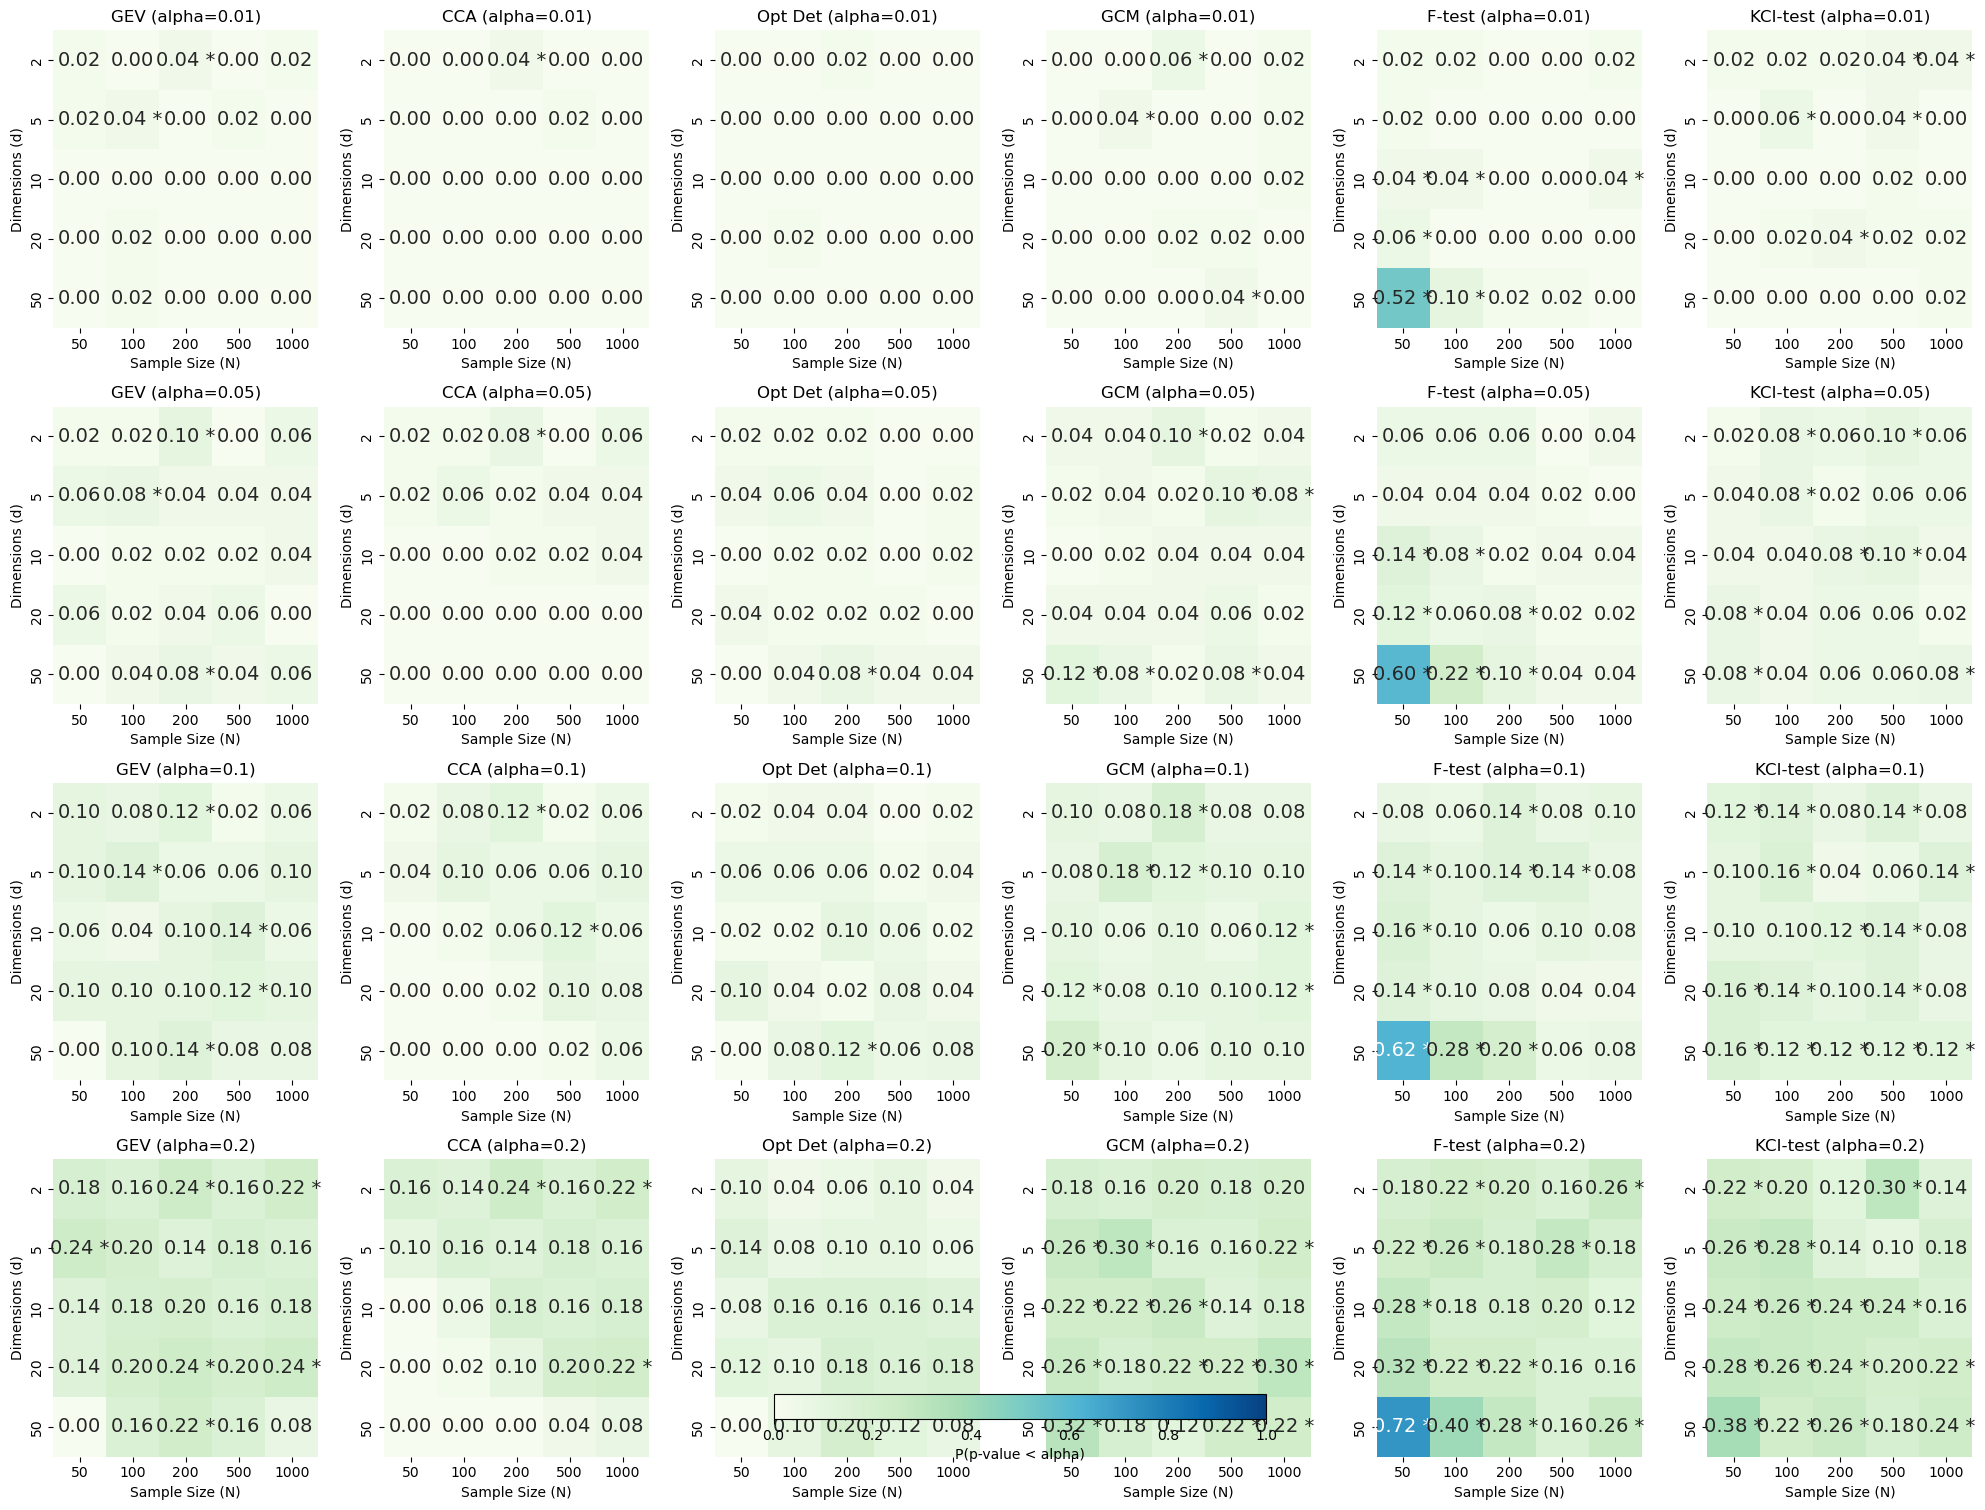

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_heatmap(data, ax, title, vmin, vmax, alpha, std_dev, significance_level=0.05, font_size=14):
    # Prepare annotations with stars for significant cells
    annotations = np.empty_like(data, dtype=object)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate Z-score and p-value for the current cell
            z_score = (data[i, j] - alpha) / std_dev
            p_val_z = 1 - norm.cdf(z_score)  # Upper-tail test
            
            # If p-value is below the significance threshold, add a star
            if p_val_z < significance_level:
                annotations[i, j] = f'{data[i, j]:.2f} *'
            else:
                annotations[i, j] = f'{data[i, j]:.2f}'
    
    # Plot the heatmap with the custom annotations
    sns.heatmap(data, annot=annotations, fmt="", cmap="GnBu", ax=ax, 
                xticklabels=[str(n) for n in samples], 
                yticklabels=[str(d) for d in dimensions],
                cbar=False, vmin=vmin, vmax=vmax,
                annot_kws={"size": font_size})
    
    ax.set_title(title)
    ax.set_xlabel('Sample Size (N)')
    ax.set_ylabel('Dimensions (d)')

# Different alpha values
alphas = [0.01, 0.05, 0.1, 0.2]
std_dev = 0.01  # Assuming Gaussian standard deviation for simplicity

# Set up the 4x4 grid of subplots
fig, axes = plt.subplots(len(alphas), 5, figsize=(20, 16))

# Loop through each alpha and create corresponding row of heatmaps
for row, alpha in enumerate(alphas):
    mean_pvals = {
        'GEV': (np.array(results['MANCOVA-pval']) < alpha).mean(axis=2)[:, :, 0],
        'CCA': (np.array(results['CCA-pval']) < alpha).mean(axis=2)[:, :, 0],
        # 'Opt Det': (np.array(results['OD-pval']) < alpha).mean(axis=2)[:, :, 0],
        'GCM': (np.array(results['GCM-pval']) < alpha).mean(axis=2)[:, :, 0],
        'F-test': (np.array(results['F-pval']) < alpha).mean(axis=2)[:, :, 0],
        'KCI-test': (np.array(results['KCI-pval']) < alpha).mean(axis=2)[:, :, 0]
    }

    # Find common vmin and vmax for all heatmaps at this alpha
    vmin = 0
    vmax = 1
    # Create heatmaps for each method (GEV, GCM, F-test, KCI-test)
    for col, (method, data) in enumerate(mean_pvals.items()):
        plot_heatmap(data, axes[row, col], f'{method} (alpha={alpha})', vmin, vmax, alpha, std_dev)

# Create a single color bar below the heatmaps
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="GnBu", norm=norm), ax=axes, orientation='horizontal', fraction=0.02, pad=0.08)
cbar.set_label('P(p-value < alpha)')

# Adjust layout to create space at the bottom for the color bar
plt.subplots_adjust(bottom=0.1)  # More space for the color bar
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Fine-tune layout

plt.show()

In [5]:
results_H1 = {
    'MANCOVA-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'MANCOVA-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))]
}


i = 0
for  d in tqdm(dimensions):
    for n_index, N in enumerate(samples):
        for b in range(B):
            A_x, A_z, beta, gamma = parameters(r, p, q, d, False)
            X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
            # MANCOVA test
            result = MANCOVA(X_train, Y_train, Z_train).results['X']['stat'].loc['Roy\'s greatest root']
            dea = DirectEffectAnalysis(type='Roy', alpha=1e-5)
            df1, df2 = result['Num DF'], result['Den DF']
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            
            pval = f.sf(F, df1, df2)
            results_H1['MANCOVA-stat'][i][n_index][b].append(F)
            results_H1['MANCOVA-pval'][i][n_index][b].append(pval)

            # Otimal Detector
            dea = DirectEffectAnalysis(type='OptiDet', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results_H1['OD-stat'][i][n_index][b].append(F)
            results_H1['OD-pval'][i][n_index][b].append(pval)

            # CCA
            dea = DirectEffectAnalysis(type='genCCA', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results_H1['CCA-stat'][i][n_index][b].append(F)
            results_H1['CCA-pval'][i][n_index][b].append(pval)
            
            # GCM test
            stat_gcm, pval_gcm = GCM_translation(X_train, Y_train, Z_train)
            results_H1['GCM-stat'][i][n_index][b].append(stat_gcm)
            results_H1['GCM-pval'][i][n_index][b].append(pval_gcm)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='FISHERZ')
            pval, stat = result.pvalue, result.statistic
            results_H1['F-stat'][i][n_index][b].append(stat)
            results_H1['F-pval'][i][n_index][b].append(pval)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='KCI')
            pval, stat = result.pvalue, result.statistic
            results_H1['KCI-stat'][i][n_index][b].append(stat)
            results_H1['KCI-pval'][i][n_index][b].append(pval)
    i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [14:20<03:35, 215.94s/it]/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:166: RuntimeWarning: divide by zero encountered in scalar divide
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:166: RuntimeWarning: invalid value encountered in scalar divide
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:197: RuntimeWarning: divide by zero encountered in scalar divide
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py:197: RuntimeWarning: invalid value encountered in scalar multiply
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/statsmodels/multivariate/multivariate_ols.py

/tmp/ipykernel_15349/1109844762.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


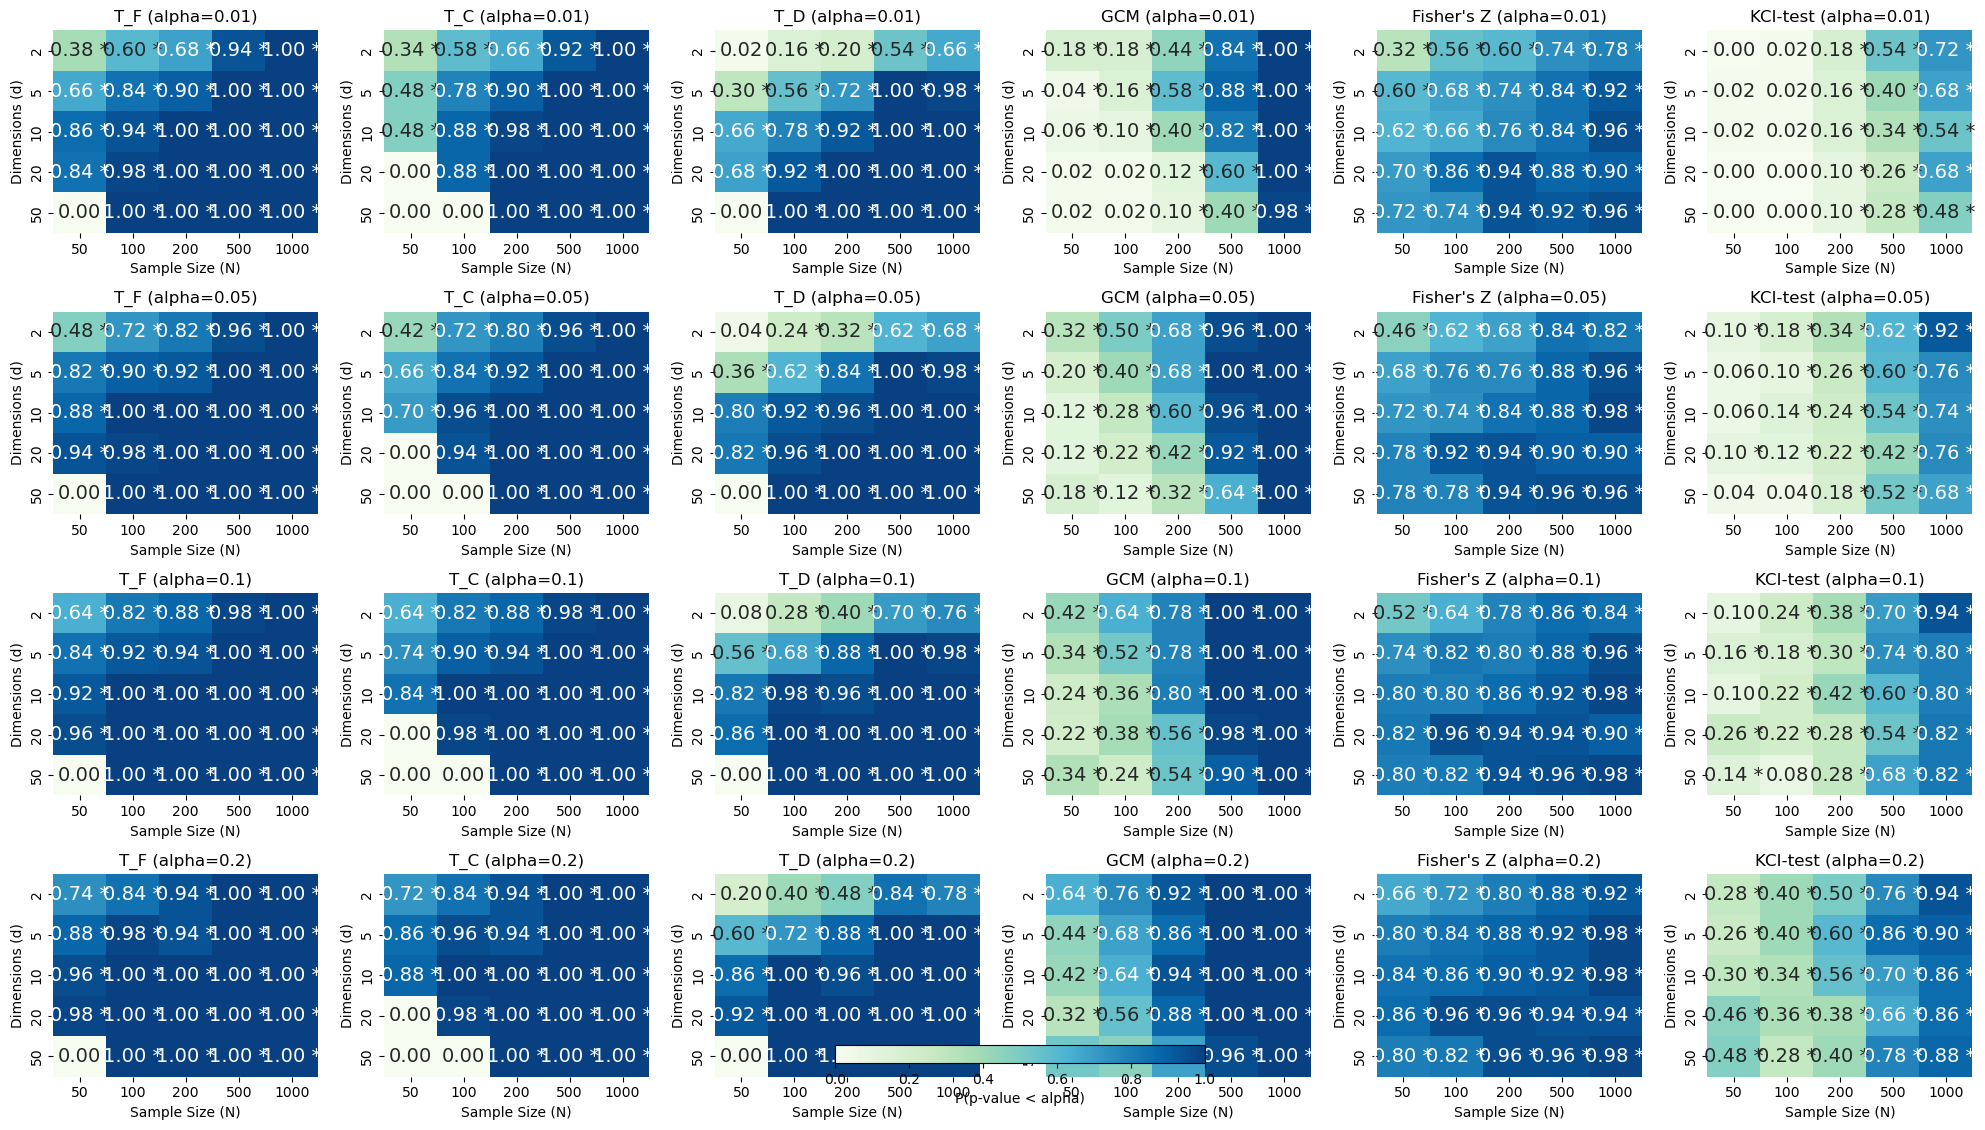

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_heatmap(data, ax, title, vmin, vmax, alpha, std_dev, significance_level=0.05, font_size=14):
    # Prepare annotations with stars for significant cells
    annotations = np.empty_like(data, dtype=object)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate Z-score and p-value for the current cell
            z_score = (data[i, j] - alpha) / std_dev
            p_val_z = 1 - norm.cdf(z_score)  # Upper-tail test
            
            # If p-value is below the significance threshold, add a star
            if p_val_z < significance_level:
                annotations[i, j] = f'{data[i, j]:.2f} *'
            else:
                annotations[i, j] = f'{data[i, j]:.2f}'
    
    # Plot the heatmap with the custom annotations
    sns.heatmap(data, annot=annotations, fmt="", cmap="GnBu", ax=ax, 
                xticklabels=[str(n) for n in samples], 
                yticklabels=[str(d) for d in dimensions],
                cbar=False, vmin=vmin, vmax=vmax,
                annot_kws={"size": font_size})
    
    ax.set_title(title)
    ax.set_xlabel('Sample Size (N)')
    ax.set_ylabel('Dimensions (d)')

# Different alpha values
alphas = [0.01, 0.05, 0.1, 0.2]
std_dev = 0.01  # Assuming Gaussian standard deviation for simplicity

# Set up the 4x4 grid of subplots
fig, axes = plt.subplots(len(alphas), 5, figsize=(20, 12))

# Loop through each alpha and create corresponding row of heatmaps
for row, alpha in enumerate(alphas):
    mean_pvals = {
        'T_F': (np.array(results_H1['MANCOVA-pval']) < alpha).mean(axis=2)[:, :, 0],
        'T_C': (np.array(results_H1['CCA-pval']) < alpha).mean(axis=2)[:, :, 0],
        # 'T_D': (np.array(results_H1['OD-pval']) < alpha).mean(axis=2)[:, :, 0],
        'GCM': (np.array(results_H1['GCM-pval']) < alpha).mean(axis=2)[:, :, 0],
        'Fisher\'s Z': (np.array(results_H1['F-pval']) < alpha).mean(axis=2)[:, :, 0],
        'KCI-test': (np.array(results_H1['KCI-pval']) < alpha).mean(axis=2)[:, :, 0]
    }

    # Find common vmin and vmax for all heatmaps at this alpha
    vmin = 0
    vmax = 1
    # Create heatmaps for each method (GEV, GCM, F-test, KCI-test)
    for col, (method, data) in enumerate(mean_pvals.items()):
        plot_heatmap(data, axes[row, col], f'{method} (alpha={alpha})', vmin, vmax, alpha, std_dev)

# Create a single color bar below the heatmaps
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="GnBu", norm=norm), ax=axes, orientation='horizontal', fraction=0.02, pad=0.08)
cbar.set_label('P(p-value < alpha)')

# Adjust layout to create space at the bottom for the color bar
plt.subplots_adjust(bottom=0.1)  # More space for the color bar
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Fine-tune layout

plt.show()

(array([0.8425812 , 0.46810067, 0.51491073, 0.1404302 , 0.1404302 ,
        0.18724027, 0.        , 0.        , 0.        , 0.04681007]),
 array([0.02940234, 0.45666086, 0.88391939, 1.31117791, 1.73843644,
        2.16569496, 2.59295349, 3.02021201, 3.44747054, 3.87472906,
        4.30198759]),
 <BarContainer object of 10 artists>)

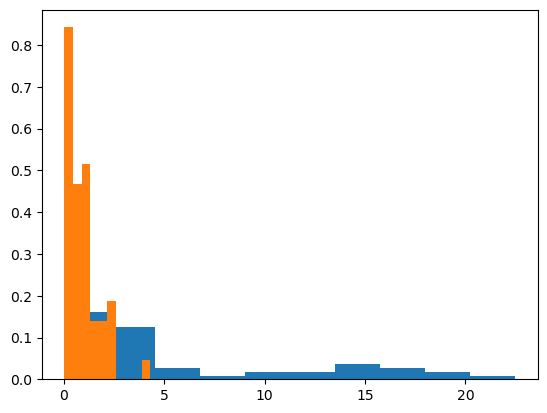

In [7]:
plt.hist(np.array(results_H1['CCA-stat'])[0, 0, :, 0], density=True)
plt.hist(np.array(results['CCA-stat'])[0, 0, :, 0], density=True)

(array([0.75621046, 0.45372628, 0.34029471, 0.07562105, 0.22686314,
        0.        , 0.        , 0.        , 0.        , 0.03781052]),
 array([0.02944081, 0.55839409, 1.08734737, 1.61630064, 2.14525392,
        2.67420719, 3.20316047, 3.73211374, 4.26106702, 4.79002029,
        5.31897357]),
 <BarContainer object of 10 artists>)

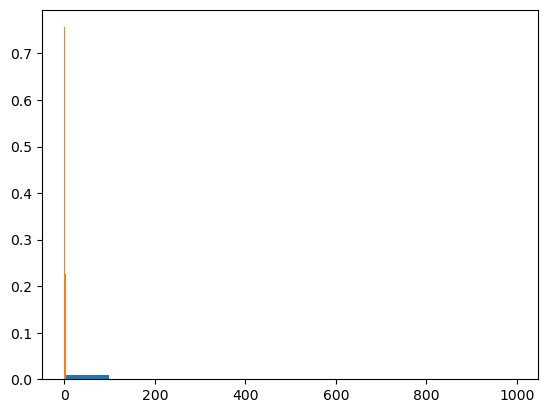

In [8]:
plt.hist(np.array(results_H1['MANCOVA-stat'])[0, 0, :, 0], density=True)
plt.hist(np.array(results['MANCOVA-stat'])[0, 0, :, 0], density=True)

(array([1.54948771, 0.25824795, 0.08608265, 0.08608265, 0.12912398,
        0.        , 0.        , 0.        , 0.        , 0.04304133]),
 array([1.33757791e-05, 4.64683083e-01, 9.29352790e-01, 1.39402250e+00,
        1.85869220e+00, 2.32336191e+00, 2.78803162e+00, 3.25270133e+00,
        3.71737103e+00, 4.18204074e+00, 4.64671045e+00]),
 <BarContainer object of 10 artists>)

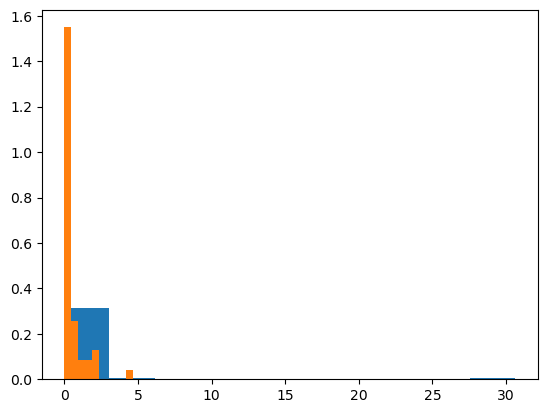

In [9]:
plt.hist(np.array(results_H1['OD-stat'])[0, 0, :, 0], density=True)
plt.hist(np.array(results['OD-stat'])[0, 0, :, 0], density=True)

In [10]:
rk, r, p, q = 10, 1, 1, 1
N = 1000
d = 10
noise = 'low_rank'
a, b, c = 0.2, 0.2, 0.6

B=500
eigenvalues_roy = []
eigenvalues_CCA = []

for b in range(B):
    A_x, A_z, beta, gamma = parameters(r, p, q, d, True)
    X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
    # CCA
    dea = DirectEffectAnalysis(type='Roy', alpha=1e-5)
    dea.fit(X_train, Y_train, Z_train)
    eigenvalues_roy.append(-dea.u[0])

    dea = DirectEffectAnalysis(type='genCCA', alpha=1e-5)
    dea.fit(X_train, Y_train, Z_train)
    eigenvalues_CCA.append(dea.u[0])


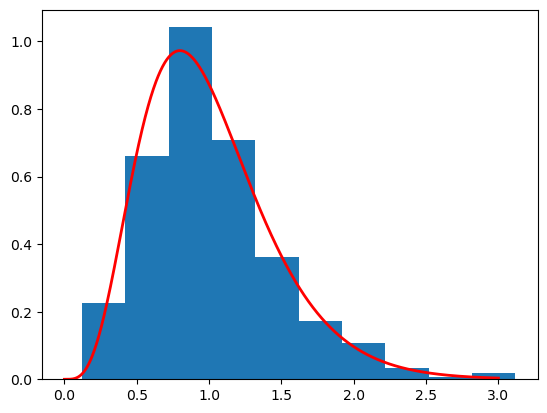

In [11]:
df1 = d
df2 = N - p - r - d - 1
plt.hist((df2/df1)*np.array(eigenvalues_roy), density=True)
x = np.linspace(0, 3, 1000)
pdf = f.pdf(x, df1, df2)
plt.plot(x, pdf, '-', lw=2, label=f'F-distribution (dfn={df1}, dfd={df2})', color='red')

/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/numpy/lib/histograms.py:884: ComplexWarning: Casting complex values to real discards the imaginary part
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6865: ComplexWarning: Casting complex values to real discards the imaginary part


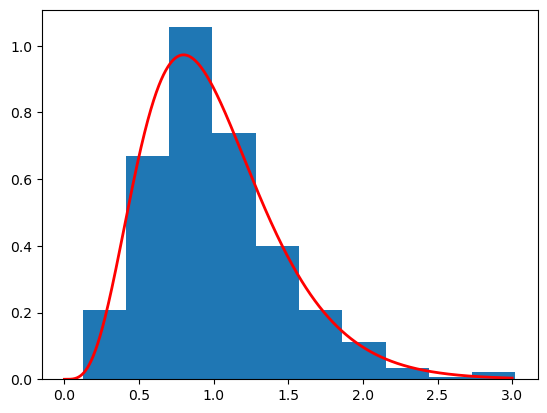

In [12]:
df1 = d
df2 = N - p - r - d - 1
plt.hist((df2/df1)*np.array(eigenvalues_CCA), density=True)
x = np.linspace(0, 3, 1000)
pdf = f.pdf(x, df1, df2)
plt.plot(x, pdf, '-', lw=2, label=f'F-distribution (dfn={df1}, dfd={df2})', color='red')